# MHD Shock solver

## Equations

In [36]:
%config InteractiveShell.ast_node_interactivity = 'last_expr_or_assign'

In [37]:
import sympy
sympy.init_printing()
def pair_across_jump(symbol, **assumptions):
    return sympy.symbols("{" + symbol + "}_{1:3}", **assumptions)
Bx = pair_across_jump("B_x", real=True)

In [38]:
Vx = pair_across_jump("V_x", real=True)

In [39]:
Vy = pair_across_jump("V_y", real=True)

In [40]:
By = pair_across_jump("B_y", real=True)

In [41]:
Eq933 = sympy.Eq(Bx[0], Bx[1])

In [42]:
Eq934 = sympy.Eq(Vx[0] * By[0] - Vy[0] * Bx[0],
                 Vx[1] * By[1] - Vy[1] * Bx[1])

In [43]:
rho = pair_across_jump(r"\rho", positive=True)

In [44]:
Eq935 = sympy.Eq(rho[0] * Vx[0],
                 rho[1] * Vx[1])

In [45]:
p = pair_across_jump("p", positive = True)

In [46]:
mu_0 = sympy.symbols("\mu_0", positive = True)

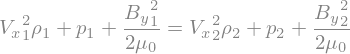

In [47]:
Eq936 = sympy.Eq(rho[0] * Vx[0]**2 + p[0] + By[0]**2 / 2 / mu_0,
                 rho[1] * Vx[1]**2 + p[1] + By[1]**2 / 2 / mu_0)

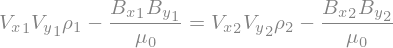

In [48]:
Eq937 = sympy.Eq(rho[0] * Vx[0] * Vy[0] - Bx[0] * By[0] / mu_0,
                 rho[1] * Vx[1] * Vy[1] - Bx[1] * By[1] / mu_0)

In [49]:
V2 = (Vx[0]**2 + Vy[0]**2, Vx[1]**2 + Vy[1]**2)

In [50]:
Gamma = sympy.symbols("Gamma", positive=True)

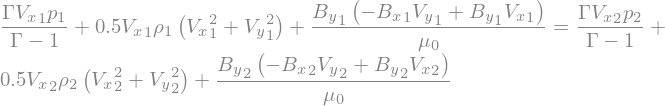

In [51]:
Eq938 = sympy.Eq(
    1/2 * rho[0] * V2[0] * Vx[0] + Gamma / (Gamma - 1) * p[0] * Vx[0] + By[0] * (Vx[0] * By[0] - Vy[0] * Bx[0]) / mu_0,
    1/2 * rho[1] * V2[1] * Vx[1] + Gamma / (Gamma - 1) * p[1] * Vx[1] + By[1] * (Vx[1] * By[1] - Vy[1] * Bx[1]) / mu_0,
)

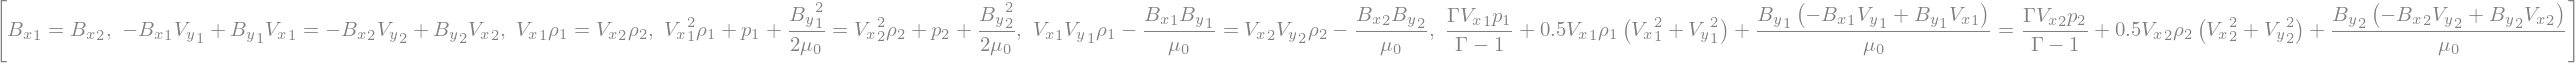

In [52]:
all_equations = [Eq933, Eq934, Eq935, Eq936, Eq937, Eq938]

In [53]:
names_to_symbols_dict = {}
for key, pair in {
    "Bx": Bx,
    "By": By,
    "Vx": Vx,
    "Vy": Vy,
    "p": p,
    "rho": rho}.items():
    for i, value in enumerate(pair):
        names_to_symbols_dict[f"{key}{i}"] = value
names_to_symbols_dict

{'Bx0': {B_x}_{1},
 'Bx1': {B_x}_{2},
 'By0': {B_y}_{1},
 'By1': {B_y}_{2},
 'Vx0': {V_x}_{1},
 'Vx1': {V_x}_{2},
 'Vy0': {V_y}_{1},
 'Vy1': {V_y}_{2},
 'p0': {p}_{1},
 'p1': {p}_{2},
 'rho0': {\rho}_{1},
 'rho1': {\rho}_{2}}

## Initial interface design

In [56]:
import time

In [71]:
import astropy.units as u
from astropy import constants
from plasmapy.utils.decorators import validate_quantities

In [118]:
@validate_quantities
def solve_RH(
    gamma: u.dimensionless_unscaled,
    Bx0: u.T = None,
    Bx1: u.T = None,
    By0: u.T = None,
    By1: u.T = None,
    Vx0: u.m/u.s = None,
    Vx1: u.m/u.s = None,
    Vy0: u.m/u.s = None,
    Vy1: u.m/u.s = None,
    rho0: u.m**-3 = None,
    rho1: u.m**-3 = None,
    p0: u.Pa = None,
    p1: u.Pa = None,
    **sympy_flags,
):
    all_arguments = dict(
        Bx0=Bx0,
        Bx1=Bx1,
        By0=By0,
        By1=By1,
        Vx0=Vx0,
        Vx1=Vx1,
        Vy0=Vy0,
        Vy1=Vy1,
        rho0=rho0,
        rho1=rho1,
        p0=p0,
        p1=p1,
    )
    if not sympy_flags:
        sympy_flags["simplify"] = False
        sympy_flags["rational"] = False
        
    for key, value in all_arguments.items():
        if value is not None:
            all_arguments[key] = value.si.value
            
    specified_arguments = {arg: value for arg, value in all_arguments.items() if value is not None}
    assert len(specified_arguments) == 6, "Problem is either overconstrained or underconstrained"
    
    solve_for_these_names = [arg for arg in all_arguments if arg not in specified_arguments]
    solve_for_these = [names_to_symbols_dict[arg] for arg in solve_for_these_names]
    print(f"I'll try to solve for these {len(solve_for_these)} unknowns:")
    display(solve_for_these)
    
    substitutions = {names_to_symbols_dict[key]: value for key, value in specified_arguments.items()}
    substitutions[Gamma] = gamma.si.value
    substitutions[mu_0] = constants.mu0.si.value
    print("Given these substitutions in SI units")
    display(substitutions)
    
    subs_equations = [eq.subs(substitutions) for eq in all_equations]
    print(f"These are the {len(subs_equations)} equations I'll be trying to solve:")
    display(subs_equations)
    
    print("Here I go!")
    start_time = time.time()
    solution = sympy.solve(subs_equations, solve_for_these,
                           simplify=False,
#                            rational=True,
                          )
    end_time = time.time()
    runtime = end_time - start_time
    print(f"That took {runtime:.2f}s...")
    print(f"We got {len(solution)} different solutions.")
    solution_dicts = [dict(zip(solve_for_these_names, sol)) for sol in solution]
    
    # ensure output dictionaries have proper units
    for solution_dict in solution_dicts:
        for key, value in solution_dict.items():
            if "B" in key:
                solution_dict[key] *= u.T
            elif "V" in key:
                solution_dict[key] *= u.m / u.s
            elif "rho" in key:
                solution_dict[key] *= u.m**-3
            elif "p" in key:
                solution_dict[key] *= u.Pa
            else:
                raise ValueError(f"What kind of a key is {key}?")
    return solution_dicts
    
output = solve_RH(
    gamma=2,
    Bx0=1 * u.T,
    By0=1 * u.T,
    Vx0=1 * u.m/u.s,
    Vy0=1 * u.m/u.s,
    rho0=1 * u.m**-3,
    p0=1 * u.Pa
)

I'll try to solve for these 6 unknowns:


Given these substitutions in SI units


These are the 6 equations I'll be trying to solve:


Here I go!
That took 6.81s...
We got 2 different solutions.


[{'Bx1': <Quantity 1. T>,
  'By1': <Quantity 1. T>,
  'Vx1': <Quantity 0.99999958 m / s>,
  'Vy1': <Quantity 0.99999958 m / s>,
  'rho1': <Quantity 1.00000042 1 / m3>,
  'p1': <Quantity 1.00000084 Pa>},
 {'Bx1': <Quantity 1. T>,
  'By1': <Quantity 1. T>,
  'Vx1': <Quantity 1. m / s>,
  'Vy1': <Quantity 1. m / s>,
  'rho1': <Quantity 1. 1 / m3>,
  'p1': <Quantity 1. Pa>}]

In [ ]:
output = solve_RH(
    gamma = 2,
    Bx0=2/3 * u.T,
    By0=2/3 * u.T,
    Vx0=1 * u.m/u.s,
    Vy0=1 * u.m/u.s,
    rho0=1 * u.m**-3,
    p0=1 * u.Pa,
)

I'll try to solve for these 6 unknowns:


Given these substitutions in SI units


These are the 6 equations I'll be trying to solve:


Here I go!


In [ ]:
output = solve_RH(
    gamma = 2,
    Bx0=0 * u.T,
    By0=0 * u.T,
    Vx0=1 * u.m/u.s,
    Vy0=1 * u.m/u.s,
    rho0=1 * u.m**-3,
    p0=1 * u.Pa,
)

In [106]:
sympy.solve?

Signature: sympy.solve(f, *symbols, **flags)
Docstring:
Algebraically solves equations and systems of equations.

Currently supported are:
    - polynomial,
    - transcendental
    - piecewise combinations of the above
    - systems of linear and polynomial equations
    - systems containing relational expressions.

Input is formed as:

* f
    - a single Expr or Poly that must be zero,
    - an Equality
    - a Relational expression
    - a Boolean
    - iterable of one or more of the above

* symbols (object(s) to solve for) specified as
    - none given (other non-numeric objects will be used)
    - single symbol
    - denested list of symbols
      e.g. solve(f, x, y)
    - ordered iterable of symbols
      e.g. solve(f, [x, y])

* flags
    'dict'=True (default is False)
        return list (perhaps empty) of solution mappings
    'set'=True (default is False)
        return list of symbols and set of tuple(s) of solution(s)
    'exclude=[] (default)'
        don't try to solve f